# Salinity Group
OOI Data Labs Workshop - March 2019

In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Request Data from OOINet

This collection of interactives will focus on Salinity data from a number of different OOI sites.

* The Exploration and Concept Invention interactives will use data from:
  * CE02SHSM-SBD11-06-METBKA000 - Coastal Endurance Array Oregon Shelf Surface Mooring, Surface Buoy  
  * Both recovered data and more recent telemetered data shoud be combined to make a complete dataset.
  * Outliers will need to be filtered out if necessary.
  * The following variables are needed: salinity, air temperature, sea surface temperature, and precipitation.
* The Application interactive will include data from 3 sites, CE02SHSH as well as:
  * CP03ISSM-SBD11-06-METBKA000 - Pioneer Inshore Surface Mooring Surface Buoy
  * GI01SUMO-SBD11-06-METBKA000 - Global Irminger Sea, Apex Surface Mooring, Surface Buoy


In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
#     'beginDT':start_date,
#     'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# # Endurance Array Oregon Shelf Surface Mooring
# request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')
# request_data('CE02SHSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument','','')

# # Pioneer Inshore Surface Mooring 
# request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')
# request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument','','')

# # Global Irminger Sea, Apex Surface Mooring 
# request_data('GI01SUMO-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')
# request_data('GI01SUMO-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument','','')

## Load, Average, Merge and Export Datasets

In [0]:
# Resultant Dataset Directories
url_ce_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202131-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_ce_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202141-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'
url_cp_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202156-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_cp_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202207-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'
url_gi_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202217-GI01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_gi_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190502T202226-GI01SUMO-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
def process_data(dataset):
  # Subset dataset
  dataset = dataset[['met_salsurf','air_temperature','sea_surface_temperature','precipitation']]

  # Remove outliers
  dataset['met_salsurf'] = dataset['met_salsurf'].where(dataset['met_salsurf']>10)
  dataset['sea_surface_temperature'] = dataset['sea_surface_temperature'].where(dataset['sea_surface_temperature']>0)

  # Average
  dataset_avg = dataset.load().resample(time='1D').mean()

  # Calculate Daily Precipitation 
  rain = dataset.precipitation.load().resample(time='15min').mean().diff('time')
  rain = rain.where(rain>0)
  rain = rain.resample(time='1D').sum()
  rain = rain.where(rain<100)
  dataset_avg['rain'] = rain
  
  return dataset_avg

## Exploration & Concept Invetion 
CE02SHSM Only

In [0]:
data_ce_rec = get_data(url_ce_rec,'velpt');
data_ce_rec_avg = process_data(data_ce_rec);

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [0]:
data_ce_tel = get_data(url_ce_tel,'velpt');
data_ce_tel_avg = process_data(data_ce_tel);

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


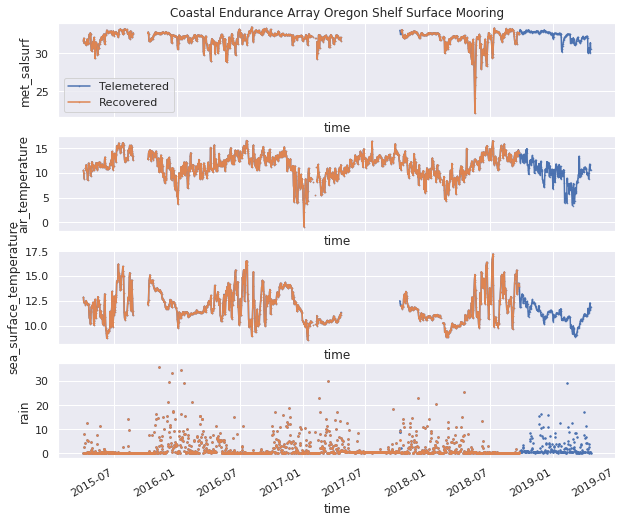

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,8))
data_ce_tel_avg.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1,label='Telemetered')
data_ce_tel_avg.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_ce_tel_avg.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_ce_tel_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

data_ce_rec_avg.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1,label='Recovered')
data_ce_rec_avg.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_ce_rec_avg.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_ce_rec_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

ax1.set_title('Coastal Endurance Array Oregon Shelf Surface Mooring')
ax1.legend();

Looks like the telemetered dataset has everything we need, so we'll just export that.

In [0]:
# Export to CSV
data_ce_tel_avg.to_dataframe().to_csv('salinity_ce02.csv')

In [0]:
# Cleanup
del data_ce_rec,data_ce_tel

## Application - All 3 Sites

### Pioneer Quicklook

In [0]:
data_cp_rec = get_data(url_cp_rec,'velpt');
data_cp_rec_avg = process_data(data_cp_rec);

In [0]:
data_cp_tel = get_data(url_cp_tel,'velpt');
data_cp_tel_avg = process_data(data_cp_tel);

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


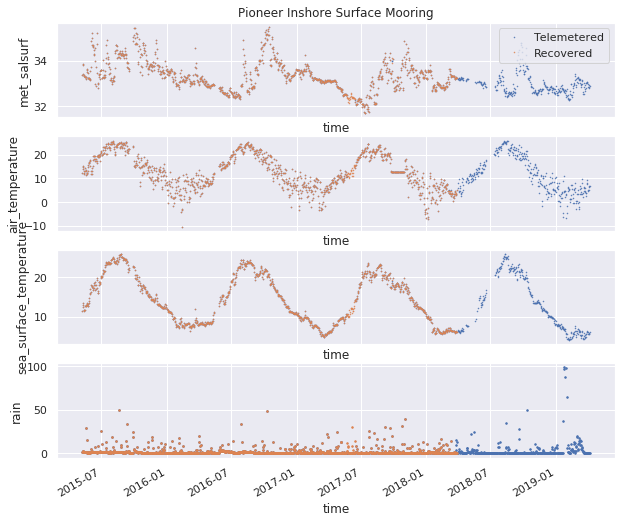

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,8))

data_cp_tel_avg.met_salsurf.plot(ax=ax1,linestyle='',marker='.',markersize=1,label='Telemetered')
data_cp_tel_avg.air_temperature.plot(ax=ax2,linestyle='',marker='.',markersize=1)
data_cp_tel_avg.sea_surface_temperature.plot(ax=ax3,linestyle='',marker='.',markersize=1)
data_cp_tel_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

data_cp_rec_avg.met_salsurf.plot(ax=ax1,linestyle='',marker='.',markersize=1,label='Recovered')
data_cp_rec_avg.air_temperature.plot(ax=ax2,linestyle='',marker='.',markersize=1)
data_cp_rec_avg.sea_surface_temperature.plot(ax=ax3,linestyle='',marker='.',markersize=1)
data_cp_rec_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

ax1.set_title('Pioneer Inshore Surface Mooring');
ax1.legend();

Ok, so there's a small gap in the telemetered dataset in June 2017, so we need to use recovered for the first few years, and then add telemetered onto the end.  For this, we can actually just merge (using combine_frist) the two datsets together, which will take any non-values from either dataset.

In [0]:
# Combine the datasets
data_cp_avg = data_cp_rec_avg.combine_first(data_cp_tel_avg)

In [0]:
# Cleanup
del data_cp_rec,data_cp_tel

### Irminger Quicklook

In [0]:
data_gi_rec = get_data(url_gi_rec,'velpt');
data_gi_rec_avg = process_data(data_gi_rec);

In [0]:
data_gi_tel = get_data(url_gi_tel,'velpt');
data_gi_tel_avg = process_data(data_gi_tel);

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


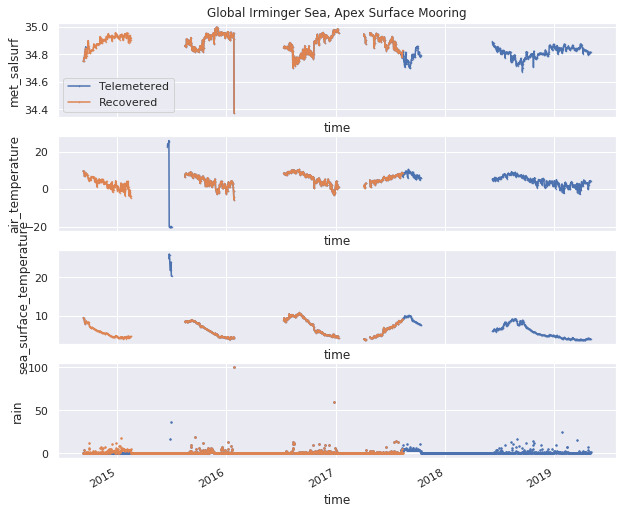

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,8))
data_gi_tel_avg.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1,label='Telemetered')
data_gi_tel_avg.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_gi_tel_avg.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_gi_tel_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

data_gi_rec_avg.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1,label='Recovered')
data_gi_rec_avg.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_gi_rec_avg.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_gi_rec_avg.rain.plot(ax=ax4,linestyle='',marker='.',markersize=3);

ax1.set_title('Global Irminger Sea, Apex Surface Mooring')
ax1.legend();

Telemetered appears to be missing much of the first deployment, so again we need to concatenate.  There's also a spurious point in the recovered dataset in 2015, so let's make a clean break between the two, using Recoverd before Fall 2017 and telemetered after.

In [0]:
# Combine datasets
cutoff = data_gi_rec_avg.time.max()
data_gi_avg = data_gi_rec_avg.combine_first(data_gi_tel_avg.sel(time = slice(cutoff,None)))

<xarray.Dataset>
Dimensions:                  (time: 1696)
Coordinates:
  * time                     (time) datetime64[ns] 2014-09-10 ... 2019-05-02
Data variables:
    met_salsurf              (time) float64 34.75 34.75 34.77 ... 34.81 34.82
    air_temperature          (time) float32 9.754777 9.2645 ... 4.559087
    sea_surface_temperature  (time) float32 9.478187 9.414536 ... 3.8898108
    precipitation            (time) float32 7.5157094 7.4512777 ... 18.439081
    rain                     (time) float32 0.061210155 0.3859477 ... 1.627924

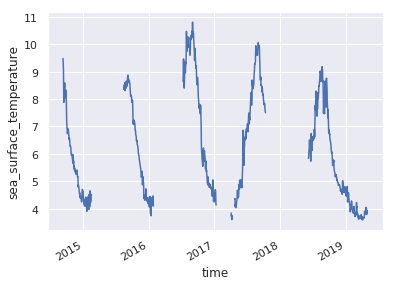

In [0]:
# Quick check
data_gi_avg.sea_surface_temperature.plot()
data_gi_avg

In [0]:
# Cleanup
del data_gi_rec,data_gi_tel

### Merge and export all 3 datasets

In [0]:
# Merge the datasets
a = data_ce_tel_avg.rename({'met_salsurf':'Endurance Salinity', 
                     'air_temperature':'Endurance Air Temp', 
                     'sea_surface_temperature':'Endurance SST',
                     'rain':'Endurance Rain'})

b = data_cp_avg.rename({'met_salsurf':'Pioneer Salinity', 
                     'air_temperature':'Pioneer Air Temp', 
                     'sea_surface_temperature':'Pioneer SST',
                     'rain':'Pioneer Rain'})

c = data_gi_avg.rename({'met_salsurf':'Irminger Salinity', 
                     'air_temperature':'Irminger Air Temp', 
                     'sea_surface_temperature':'Irminger SST',
                     'rain':'Irminger Rain'})
a = a.drop(['precipitation'])
b = b.drop(['precipitation'])
c = c.drop(['precipitation'])

x = xr.merge([a,b,c]).to_dataframe()
x.head()

,Endurance Salinity,Endurance Air Temp,Endurance SST,Endurance Rain,Pioneer Salinity,Pioneer Air Temp,Pioneer SST,Pioneer Rain,Irminger Salinity,Irminger Air Temp,Irminger SST,Irminger Rain
time,,,,,,,,,,,,
2014-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.749142,9.754777,9.478187,0.061210
2014-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.753739,9.264500,9.414536,0.385948
2014-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.773249,8.552961,9.199367,0.407545
2014-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.773831,9.461617,9.080827,4.061524
2014-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.781400,6.761691,8.465412,0.266571


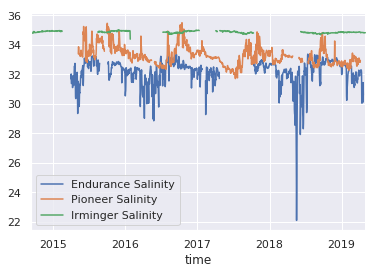

In [0]:
x[['Endurance Salinity','Pioneer Salinity','Irminger Salinity']].plot();

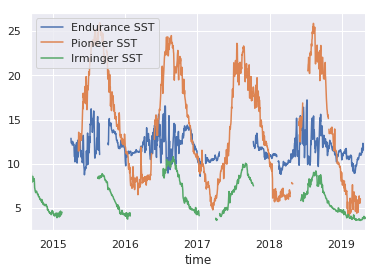

In [0]:
x[['Endurance SST','Pioneer SST','Irminger SST']].plot();

In [0]:
# Export to CSV
x.to_csv('salinity_application.csv')